# Rydberg State Preparation
In this notebook, we applied the three-level optical bloch equations to study the excitation of the rydberg states. We try to explore the optimal values of parameters we should use to excite the atoms. To solve the three-level OBEs, we utilised a fourier transform approach to convert the differential equations to linear equations. By finding the eigenvalues of the matrix, we can write the final solution as the sum of nine 'normal modes'. For more details, please see the document: Solving_OBEs_transform_method.ipynb.
The form of the three-level OBEs we are using is from https://opg.optica.org/oe/fulltext.cfm?uri=oe-19-12-11128&id=214222.

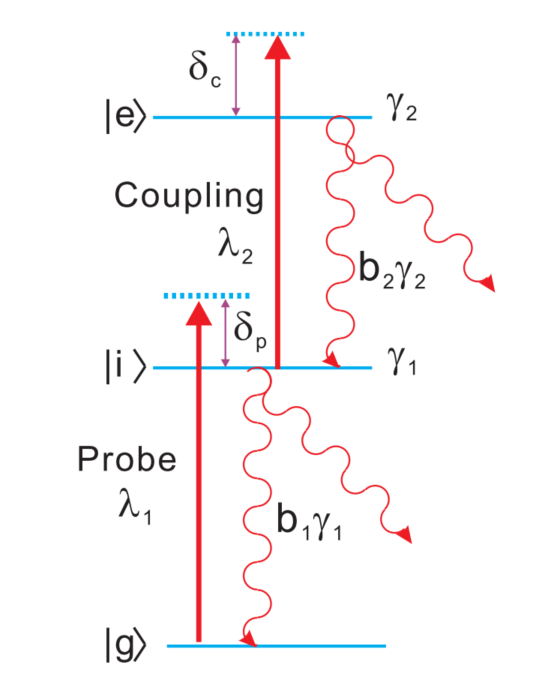





In [1]:
# Import libaries and modules.
import matplotlib.pyplot as plt  # Import library for direct plotting functions
import numpy as np  # Import Numerical Python
from IPython.display import display, HTML  # Import HTML for formatting output
from scipy.integrate import ode  # Import ODE solver
from scipy.integrate import solve_ivp  # Import ODE solver
import scipy.constants as cts  # Import physical constants
from arc import *
from equations import *
from solver import *


ModuleNotFoundError: No module named 'equations'

In [2]:
# Some experimental parameters and constants
# Physical constants
a_0 = cts.physical_constants['Bohr radius'][0]  # Bohr radius in meters
e = cts.e  # Electron charge in Coulombs  
hbar = cts.hbar  # Planck's constant divided by 2*pi in J*s 
epsilon = cts.epsilon_0  # Vacuum permittivity in Farads/meter
c = cts.c  # Speed of light in meters/second

# Laser power and waist
'''
P1 = 2e-6  # Laser1 power in W
W1 = 42e-6  # Laser1 waist in m
P2 = 2e-3  # Laser2 power in W
W2 = 9e-6  # Laser2 waist in m

I1= P1/(np.pi*(W1)**2) #Intensity of the probe laser in W/m^2
I2= P2/(np.pi*(W2)**2)#Intensity of the coupling laser in W/m^2

E1 = np.sqrt(2*I1/(epsilon*c)) # Strength of the probe electric field in V/m
E2 = np.sqrt(2*I2/(epsilon*c)) # Strength of the coupling electric field in V/m
print('E1=' + str(E1))
print('E2=' + str(E2))
'''

"\nP1 = 2e-6  # Laser1 power in W\nW1 = 42e-6  # Laser1 waist in m\nP2 = 2e-3  # Laser2 power in W\nW2 = 9e-6  # Laser2 waist in m\n\nI1= P1/(np.pi*(W1)**2) #Intensity of the probe laser in W/m^2\nI2= P2/(np.pi*(W2)**2)#Intensity of the coupling laser in W/m^2\n\nE1 = np.sqrt(2*I1/(epsilon*c)) # Strength of the probe electric field in V/m\nE2 = np.sqrt(2*I2/(epsilon*c)) # Strength of the coupling electric field in V/m\nprint('E1=' + str(E1))\nprint('E2=' + str(E2))\n"

In [6]:
# The three levels we use
# For Rb, we chose g,i,e as 5S1/2, 5P3/2, 5D5/2
# Note: All frequencies below are in radian per second
atom = Rubidium()
# Ground state, 5S1/2
ng = 5
lg = 0
jg = 1/2
fg = 2
mfg = 0
mjg = 1/2
# Intermdiate state, 5P3/2
ni = 5
li = 1
ji = 3/2
fi = 2
mfi = 1
mji = 1/2
# Final state, 60S1/2
nf = 60
lf = 0
ff = 2
mff = 1
jf = 1/2
mjf = 0

### Calculation of branching ratios b1 and b2
In this section, we try to calculate the branching ratios b1 and b2 by adding all the possibilities of total orbital angular momentum numbers f and mf. For different atoms, the spin of nuclei is different, so values of f and mf are different.

In [4]:
# Calculate b1 and b2
'''
fg_range = np.arange(abs(jg-3/2),abs(jg+3/2)+1,1)
fi_range = np.arange(abs(ji-3/2),abs(ji+3/2)+1,1)
ff_range = np.arange(abs(jf-3/2),abs(jf+3/2)+1,1)
print(fg_range)
print(fi_range)
fg_values, fi_values = np.meshgrid(fg_range,fi_range)
b1_total=0

# Calculate the number of possibilites for the initial state
initial_state = 0
for fi in fi_range:
    initial_state += 2*fi+1

print(initial_state)


# Add up all the possible branching ratios between the ground state and the intermediate state
for fg in fg_range:
    for fi in fi_range:
        mfg_range = np.arange(-fg,fg+1,1)
        mfi_range = np.arange(-fi,fi+1,1)
        mfg, mfi = np.meshgrid(mfg_range,mfi_range)
        try:
            b1s = np.vectorize(atom.getBranchingRatio)(jg = jg, fg = fg, mfg = mfg,
                                    je = ji, fe = fi, mfe = mfi)
            b1_total += np.sum(b1s)
        except:
            pass
b1 = b1_total/initial_state


initial_statef = 0
for ff in ff_range:
    initial_statef += 2*ff+1

b2_total = 0
for fi in fi_range:
    for ff in ff_range:
        mfi_range = np.arange(-fi,fi+1,1)
        mff_range = np.arange(-ff,ff+1,1)
        mfi, mff = np.meshgrid(mfi_range,mff_range)
        try:
            b2s = np.vectorize(atom.getBranchingRatio)(jg = ji, fg = fi, mfg = mfi,
                                    je = jf, fe = ff, mfe = mff)
            b2_total += np.sum(b2s)
        except:
            pass
b2 = b2_total/initial_statef


print(b1)
print(b2)
'''


[1. 2.]
[0. 1. 2. 3.]
16.0
0.625
0.625


In [8]:
b1 = atom.getBranchingRatio(jf, ff, mff, jg, fg, mfg) # Branching ratio from 60S1/2 to 5S1/2

b2 = atom.getBranchingRatio(ji, fi, mfi, jg, fg, mfg) # Branching ratio from 5P3/2 to 5S1/2

print(f'b1 = {b1}')
print(f'b2 = {b2}')

b1 = 0.11111111111111112
b2 = 0.19444444444444442


In [8]:


#Rabi Frequency 1e6-100e6
'''
Omega1 = atom.getRabiFrequency2(n1= ng, l1= lg, j1= jg, mj1= mjg, 
                                    n2= ni, l2= li, j2= ji, q=0 ,
                                    electricFieldAmplitude= E1)


Omega2 = atom.getRabiFrequency2(n1= ni, l1= li, j1= ji, mj1= mji,
                                    n2= nf, l2= lf, j2= jf, q=0,
                                    electricFieldAmplitude= E2)
Omega1 = 1e8
Omega2 = 1e8

print('Omega1=2*pi*'+ str("{:e}".format(Omega1/(2*np.pi))) + 'Hz'+'='+ str("{:e}".format(Omega1)))
print('Omega2=2*pi*'+ str("{:e}".format(Omega2/(2*np.pi)))+ 'Hz'+'='+ str("{:e}".format(Omega2)))
'''
# Sponetaous Decay rates
gamma1 = 1/atom.getStateLifetime(n = ni, l = li, j = ji)
lifetime1 = atom.getStateLifetime(n = ni, l = li, j = ji)
gamma2 = 1/atom.getStateLifetime(n = nf, l = lf, j = jf)
lifetime2 = atom.getStateLifetime(n = nf, l = lf, j = jf)


print('gamma1='+ str("{:e}".format(gamma1)))
print('gamma2='+ str("{:e}".format(gamma2)))
print('lifetime1='+ str("{:e}".format(lifetime1)))
print('lifetime2='+ str("{:e}".format(lifetime2)))












gamma1=3.811316e+07
gamma2=4.342133e+03
lifetime1=2.623766e-08
lifetime2=2.303016e-04


In [11]:
'''
# Some parameters, calculators
Omega1 = 1e6
Omega2 = 1e6

print('Omega1=2*pi*'+ str("{:e}".format(Omega1/(2*np.pi))) + 'Hz'+'='+ str("{:e}".format(Omega1)))
print('Omega2=2*pi*'+ str("{:e}".format(Omega2/(2*np.pi)))+ 'Hz'+'='+ str("{:e}".format(Omega2)))

# Detuning

delta11 = np.sqrt(gamma1/gamma2)*np.sqrt(Omega1*Omega2)/2
delta11u = np.sqrt(gamma1/gamma2)*Omega1/2
delta11l = np.sqrt(gamma1/gamma2)*Omega2/2

delta = (np.abs(Omega2)**2-np.abs(Omega1)**2)/(4*(delta11))
delta2 = delta - delta11
deltaeff = (delta11+delta2)-(np.abs(Omega1)**2-np.abs(Omega2)**2)/(4*(delta11))
deltashift = (np.abs(Omega1)**2-np.abs(Omega2)**2)/(4*(delta11))

print('delta1=2*pi*'+ str("{:e}".format(delta11/(2*np.pi))) + 'Hz'+'='+ str("{:e}".format(delta11)))
print('delta11u=2*pi*'+ str("{:e}".format(delta11u/(2*np.pi))) + 'Hz'+'='+ str("{:e}".format(delta11u)))
print('delta11l=2*pi*'+ str("{:e}".format(delta11l/(2*np.pi))) + 'Hz'+'='+ str("{:e}".format(delta11l)))

print('delta2=2*pi*'+ str("{:e}".format(delta2/(2*np.pi)))+ 'Hz'+'='+ str("{:e}".format(delta2))) 

print('delta=2*pi*'+ str("{:e}".format(delta/(2*np.pi)))+ 'Hz'+'='+ str("{:e}".format(delta)))
print('deltaeff=2*pi*'+ str("{:e}".format(deltaeff/(2*np.pi)))+ 'Hz'+'='+ str("{:e}".format(deltaeff)))
print('deltashift=2*pi*'+ str("{:e}".format(deltashift/(2*np.pi)))+ 'Hz'+'='+ str("{:e}".format(deltashift)))

Omegaeff = Omega1*Omega2/(2*delta11)

period = 2*np.pi/Omegaeff

print('Omegaeff=2*pi*'+ str("{:e}".format(Omegaeff/(2*np.pi)))+ 'Hz'+'='+ str("{:e}".format(Omegaeff)))
print('period='+ str("{:e}".format(period)))
'''



'\n# Some parameters, calculators\nOmega1 = 1e6\nOmega2 = 1e6\n\nprint(\'Omega1=2*pi*\'+ str("{:e}".format(Omega1/(2*np.pi))) + \'Hz\'+\'=\'+ str("{:e}".format(Omega1)))\nprint(\'Omega2=2*pi*\'+ str("{:e}".format(Omega2/(2*np.pi)))+ \'Hz\'+\'=\'+ str("{:e}".format(Omega2)))\n\n# Detuning\n\ndelta11 = np.sqrt(gamma1/gamma2)*np.sqrt(Omega1*Omega2)/2\ndelta11u = np.sqrt(gamma1/gamma2)*Omega1/2\ndelta11l = np.sqrt(gamma1/gamma2)*Omega2/2\n\ndelta = (np.abs(Omega2)**2-np.abs(Omega1)**2)/(4*(delta11))\ndelta2 = delta - delta11\ndeltaeff = (delta11+delta2)-(np.abs(Omega1)**2-np.abs(Omega2)**2)/(4*(delta11))\ndeltashift = (np.abs(Omega1)**2-np.abs(Omega2)**2)/(4*(delta11))\n\nprint(\'delta1=2*pi*\'+ str("{:e}".format(delta11/(2*np.pi))) + \'Hz\'+\'=\'+ str("{:e}".format(delta11)))\nprint(\'delta11u=2*pi*\'+ str("{:e}".format(delta11u/(2*np.pi))) + \'Hz\'+\'=\'+ str("{:e}".format(delta11u)))\nprint(\'delta11l=2*pi*\'+ str("{:e}".format(delta11l/(2*np.pi))) + \'Hz\'+\'=\'+ str("{:e}".format(delt

In [9]:
# Some useful functions
# The function will find the optimal value for delta1

# Initial condition
y0 = np.array([0,0,1+0j,0,0,0,0,0,0],dtype=complex)

def find_optimal_delta(Omega1, Omega2, y0 = y0):
    # The function that finds the optimal value of delta1 
    # for  given values of Omega1 and Omega2
    # Theoretical approximation of optimal delta1
    delta1o = np.sqrt(gamma1/gamma2)*np.sqrt((Omega2**2+Omega1**2)/2)/2
    # delta1 values that we will explore
    delta1s = np.arange(0.9*delta1o, 2*delta1o, 0.01*delta1o)
    # Initial conditions
    # A list to store the maximum value of rho_ee
    rho_ee_maxs = [] 
    for delta1 in delta1s:
        #Calculate delta2
        delta = (np.abs(Omega2)**2-np.abs(Omega1)**2)/(4*(delta1))
        delta2 = delta - delta1
        Omegaeff = Omega1*Omega2/(2*delta1)
        t = np.linspace(0, 1.5*np.pi/Omegaeff, 1000)
        rho_ee = matrix_solver(t,y0,Omega1, Omega2, gamma1, gamma2, delta1, delta2, b1, b2)
        #Store the values of the maximum rho_ee
        rho_ee_maxs.append(max(rho_ee))
    #Find the maximum value of rho_ee
    optimal_rho_ee = max(rho_ee_maxs)
    index = rho_ee_maxs.index(optimal_rho_ee)
    #Find the corresponding value of delta1
    optimal_delta1 = delta1s[index]
    return optimal_delta1

def find_max_rho_ee(Omega1, Omega2, delta1, y0 = y0):
    # The function that finds the maximum value of rho_ee for a given Omega1, Omega2 and delta1
    delta = (np.abs(Omega2)**2-np.abs(Omega1)**2)/(4*(delta1))
    delta2 = delta - delta1
    Omegaeff = Omega1*Omega2/(2*delta1)
    time_span = (0, 1.5*np.pi/Omegaeff)
    t = np.linspace(0, 1.5*np.pi/Omegaeff, 1000)
    rho_ee = matrix_solver(t,y0,Omega1, Omega2, gamma1, gamma2, delta1, delta2, b1, b2)
    return max(rho_ee)
    


## Relationship between the optimal delta and two rabi frequencies
In this section we plot the optimal delta as a function of Omega1 and Omega2

In [10]:
# Creates a meshgrid of Omega1 and Omega2 values
# Save the solution data
file_name = 'data/soln.npz'
Omega1s = np.linspace(1e6, 100e6, 100)
Omega2s = np.linspace(1e6, 100e6, 100)
Omega1, Omega2 = np.meshgrid(Omega1s, Omega2s)

In [14]:
# Get the values of delta1_optimal for each pair of Omega1 and Omega2

delta1_optimal = np.vectorize(find_optimal_delta)(Omega1, Omega2)



np.savez(file_name, Omega1, Omega2, delta1_optimal, 
            Omega1=Omega1, Omega2=Omega2, delta1_optimal=delta1_optimal)



In [11]:
# load the data
file_name = 'data/soln.npz'
Omega1 = np.load(file_name)['Omega1']
Omega2 = np.load(file_name)['Omega2']
delta1_optimal = np.load(file_name)['delta1_optimal']

In [12]:
def model1_delta(Omega1, Omega2, gamma1, gamma2):
    delta1om = np.sqrt(gamma1/gamma2)*np.sqrt((Omega2**2+Omega1**2)/2)/2
    return delta1om

delta1om = np.vectorize(model1_delta)(Omega1, Omega2, gamma1, gamma2)
fractional_difference = (delta1_optimal - delta1om)/delta1om


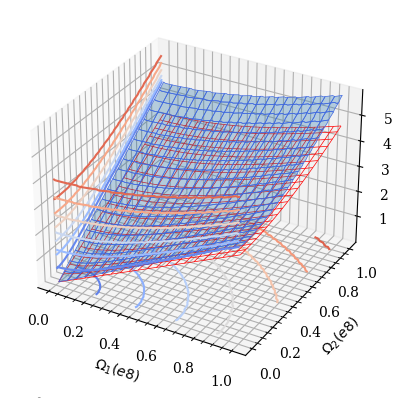

In [13]:

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig=plt.figure()
ax = fig.add_subplot(111,projection='3d')

surf = ax.plot_surface(Omega1, Omega2, delta1_optimal, edgecolor='royalblue', lw=0.5, rstride=5, cstride=5,
                alpha=0.3)
ax.plot_wireframe(Omega1, Omega2, delta1om, rstride=5, cstride=5, color='red', linewidths=0.5)
#ax.scatter3D(Omega1, Omega2, delta1_optimal)
ax.contour(Omega1, Omega2, delta1_optimal, zdir='z', offset=-100, cmap='coolwarm')
ax.contour(Omega1, Omega2, delta1_optimal, zdir='x', offset=-40, cmap='coolwarm')
ax.contour(Omega1, Omega2, delta1_optimal, zdir='y', offset=40, cmap='coolwarm')

ax.set(xlabel=r'$\Omega_1(e8)$', ylabel=r'$\Omega_2(e8)$', zlabel=r'$\delta_{optimal}(e8)$')

plt.show()



C:\Users\Chen\AppData\Local\Temp\ipykernel_13768\1649829076.py:1: UserWarning: The following kwargs were not used by contour: 'zdir', 'offset'
  C = plt.contourf(Omega1, Omega2, delta1_optimal, zdir='z', offset=0, cmap=cm.coolwarm)


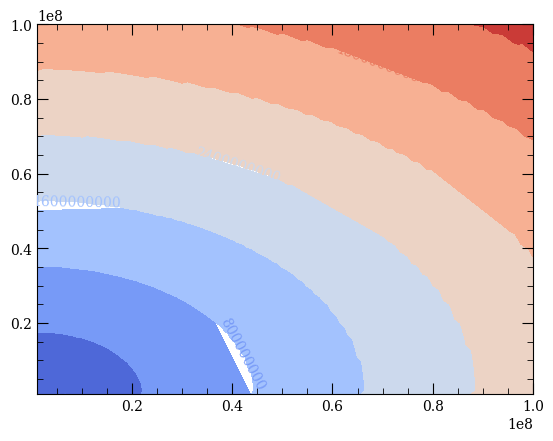

In [14]:
C = plt.contourf(Omega1, Omega2, delta1_optimal, zdir='z', offset=0, cmap=cm.coolwarm)
plt.clabel(C,inline=True, fontsize=10)
ax.set_xlabel('Omega1')
ax.set_ylabel('Omega2')
ax.set_zlabel('Delta1_optimal')
plt.show()

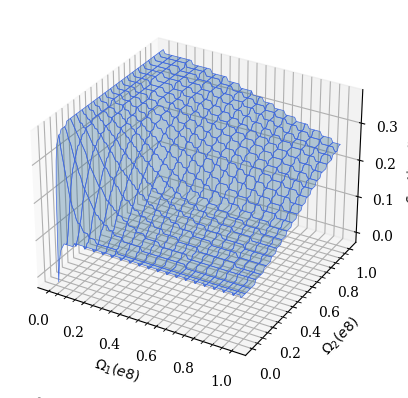

In [16]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig=plt.figure()
ax = fig.add_subplot(111,projection='3d')

surf = ax.plot_surface(Omega1, Omega2, fractional_difference, edgecolor='royalblue', lw=0.5, rstride=5, cstride=5,
                alpha=0.3)

ax.set(xlabel=r'$\Omega_1(e8)$', ylabel=r'$\Omega_2(e8)$', zlabel=r'$\delta_optimal(e8)$')

plt.show()

## Relationship between the maximum rho_ee and delta1

In [20]:
# Omega values

Omega1 = 1.5e7
Omega2 = 1.5e7

In [21]:
# Find the maximum rho_ee for different delta1s
file_name2 = 'single_omega/rhomaxvsdelta.npz'
# Theoretical maximum delta1o
delta1o = np.sqrt(gamma1/gamma2)*np.sqrt((Omega1**2+Omega2**2)/2)/2
# delta1 values that we will explore
delta1s = np.arange(0.1*delta1o, 2*delta1o, 0.1*delta1o)

# A list to store the maximum value of rho_ee

rho_ee_maxs = np.vectorize(find_max_rho_ee)(Omega1, Omega2, delta1s)
print(rho_ee_maxs)
# Find the maximum value of rho_ee
optimal_rho_ee = max(rho_ee_maxs)
index = np.where(rho_ee_maxs == optimal_rho_ee)[0][0]
#Find the corresponding value of delta1
optimal_delta1 = delta1s[index]
print('optimal_delta1='+ str("{:e}".format(optimal_delta1)))
np.savez(file_name2, Omega1, Omega2, rho_ee_maxs, delta1s, optimal_delta1, optimal_rho_ee,
            Omega1=Omega1, Omega2=Omega2, rho_ee_maxs=rho_ee_maxs, delta1s=delta1s, 
                optimal_delta1=optimal_delta1, optimal_rho_ee=optimal_rho_ee)
            
            


[0.62934057-2.92815965e-15j 0.76392153+7.78010114e-15j
 0.82451612-8.87239534e-15j 0.85729819+1.97820797e-14j
 0.87700623-3.24995983e-15j 0.88958103+5.30017926e-15j
 0.89785246+4.98214379e-14j 0.90333305+2.10403763e-13j
 0.90690491-1.62164465e-14j 0.90911622+3.14176709e-14j
 0.91032536+2.05704282e-14j 0.91077641-1.24150066e-13j
 0.91064175+2.01195670e-13j 0.91004669+1.06431919e-13j
 0.90908268-4.43399707e-13j 0.90781974-9.98807328e-14j
 0.90631187+2.80878389e-16j 0.90460197-2.72693115e-13j
 0.90272484-1.50516945e-13j 0.90070583+2.12125364e-13j]
optimal_delta1=8.431957e+08


In [22]:
# Calculate the theoretical maximum values of delta1 and rho_ee
file_name3 = 'single_omega/rhomaxvsdelta_max.npz'
# Theoretical optimal delta1
deltaot = np.sqrt(gamma1/gamma2)*np.sqrt((Omega1**2+Omega2**2)/2)/2  
rho_maxt = find_max_rho_ee(Omega1, Omega2, deltaot)

np.savez(file_name3, Omega1, Omega2, deltaot, rho_maxt,
            Omega1=Omega1, Omega2=Omega2, deltaot=deltaot, rho_maxt=rho_maxt)


In [23]:
# Theoretical optimal delta2
deltaot2 = np.sqrt(gamma1/gamma2)*np.sqrt((Omega2**2+Omega2**2)/2)/2  
rho_maxt2 = find_max_rho_ee(Omega1, Omega2, deltaot2)
file_name4 = 'single_omega/rhomaxvsdelta_max2.npz'
np.savez(file_name4, Omega1, Omega2, deltaot2, rho_maxt2,
            Omega1=Omega1, Omega2=Omega2, deltaot2=deltaot2, rho_maxt2=rho_maxt2)


In [24]:
# Plot the model 1,2, A-B/delta-C*delta

def model1(Omega1, Omega2, delta1):
    f = 1 + ((2*delta1*np.pi)/(Omega1*Omega2))**2*(Omega1**2+Omega2**2)/2*gamma1*gamma2/(4*delta1**2) -\
    ((2*delta1*np.pi)/(Omega1*Omega2))*(Omega1**2+Omega2**2)/2*gamma1/(4*delta1**2)- \
    gamma2*((2*delta1*np.pi)/(Omega1*Omega2))
    return f

def model2(Omega1, Omega2, delta1):
    f = 1 + ((2*delta1*np.pi/2)/(Omega1*Omega2))**2*(Omega1**2+Omega2**2)/2*gamma1*gamma2/(4*delta1**2) -\
    ((2*delta1*np.pi/2)/(Omega1*Omega2))*(Omega1**2+Omega2**2)/2*gamma1/(4*delta1**2)- \
    gamma2*((2*delta1*np.pi/2)/(Omega1*Omega2))
    return f

rho_eem1 = np.vectorize(model1)(Omega1, Omega2, delta1s)
rho_eem2 = np.vectorize(model2)(Omega1, Omega2, delta1s)

In [25]:
# Load variables
file_name2 = 'single_omega/rhomaxvsdelta.npz'
file_name3 = 'single_omega/rhomaxvsdelta_max.npz'
file_name4 = 'single_omega/rhomaxvsdelta_max2.npz'

delta1s = np.load(file_name2)['delta1s']
rho_ee_maxs = np.load(file_name2)['rho_ee_maxs']
optimal_delta1 = np.load(file_name2)['optimal_delta1']
optimal_rho_ee = np.load(file_name2)['optimal_rho_ee']
Omega1 = np.load(file_name2)['Omega1']
Omega2 = np.load(file_name2)['Omega2']
deltaot = np.load(file_name3)['deltaot']
rho_maxt = np.load(file_name3)['rho_maxt']
deltaot2 = np.load(file_name4)['deltaot2']
rho_maxt2 = np.load(file_name4)['rho_maxt2']


c:\Users\Chen\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


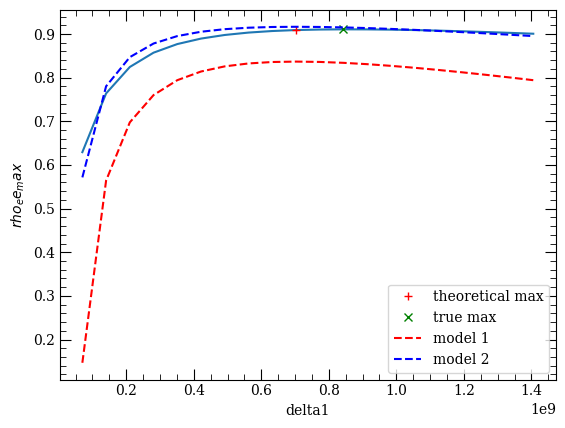

In [26]:
# Plot the results
fig, ax = plt.subplots()

plt.plot(delta1s,rho_ee_maxs)
plt.plot(deltaot,rho_maxt,'r+', label='theoretical max')
#plt.plot(deltaot2,rho_maxt2,'b+', label='theoretical max2')
plt.plot(optimal_delta1, optimal_rho_ee,'gx', label = 'true max')

plt.plot(delta1s,rho_eem1,'r--', label='model 1')
plt.plot(delta1s,rho_eem2,'b--', label='model 2')
plt.xlabel('delta1')
plt.ylabel('$rho_ee_max$')

plt.legend()
plt.show()

## Effective Two-level Optical bloch equations
We can study the effective two-level optical bloch equations and compare them with the three-level optical bloch equations.

In [27]:
#gamma1 = 0
#gamma2 = 0

In [28]:
# Solve the optical bloch equations
# Initial conditions

'''
y0 = [1, 0, 0, 0, 0, 0, 0, 0, 0]
# Time grid
t = np.linspace(0, 2*np.pi/Omegaeff, 1000)
# Solve the ODEs
r=ode(three_level_OBEs).set_integrator('zvode')
r.set_initial_value(y0).set_f_params(gamma2,Omega2,gamma1,Omega1,b1,b2,delta1,delta2)
# Store the value
rhos = [rho_gg, rho_ii, rho_ee, rho_gi, 
    rho_ig, rho_ge, rho_eg, rho_ie, rho_ei] = [np.zeros(len(t), dtype=complex) for i in range(9)]
index = 0
for rho in rhos:
    rho[0] = y0[index]
    index += 1

#Integration
for i in range(1, len(t)):
    r.integrate(t[i])
    index = 0
    for rho in rhos:
        rho[i] = r.y[index]
        index += 1
'''

"\ny0 = [1, 0, 0, 0, 0, 0, 0, 0, 0]\n# Time grid\nt = np.linspace(0, 2*np.pi/Omegaeff, 1000)\n# Solve the ODEs\nr=ode(three_level_OBEs).set_integrator('zvode')\nr.set_initial_value(y0).set_f_params(gamma2,Omega2,gamma1,Omega1,b1,b2,delta1,delta2)\n# Store the value\nrhos = [rho_gg, rho_ii, rho_ee, rho_gi, \n    rho_ig, rho_ge, rho_eg, rho_ie, rho_ei] = [np.zeros(len(t), dtype=complex) for i in range(9)]\nindex = 0\nfor rho in rhos:\n    rho[0] = y0[index]\n    index += 1\n\n#Integration\nfor i in range(1, len(t)):\n    r.integrate(t[i])\n    index = 0\n    for rho in rhos:\n        rho[i] = r.y[index]\n        index += 1\n"

In [29]:
'''
def two_level_rabi_oscillation(t,y,Omega,delta):
    # Omega is the Rabi frequency
    # delta is the detuning
    c1=y[0]
    c2=y[1]
    dc1dt=-1j/2*Omega*np.exp(1j*delta*t)*c2
    dc2dt=-1j/2*Omega*np.exp(-1j*delta*t)*c1
    dydt=[dc1dt,dc2dt]
    return dydt
'''

'\ndef two_level_rabi_oscillation(t,y,Omega,delta):\n    # Omega is the Rabi frequency\n    # delta is the detuning\n    c1=y[0]\n    c2=y[1]\n    dc1dt=-1j/2*Omega*np.exp(1j*delta*t)*c2\n    dc2dt=-1j/2*Omega*np.exp(-1j*delta*t)*c1\n    dydt=[dc1dt,dc2dt]\n    return dydt\n'

In [30]:
# Effective Rabi frequency and detuning
'''
Omegaeff = Omega1*Omega2/(2*delta1)
deltaeff = (delta1+delta2)-(np.abs(Omega1)**2-np.abs(Omega2)**2)/(4*(delta1))
'''

'\nOmegaeff = Omega1*Omega2/(2*delta1)\ndeltaeff = (delta1+delta2)-(np.abs(Omega1)**2-np.abs(Omega2)**2)/(4*(delta1))\n'

In [31]:
#Solve for the effective Rabi oscillation
#Initial conditions
'''
y0=[1,0]
r=ode(two_level_rabi_oscillation).set_integrator('zvode')
r.set_initial_value(y0).set_f_params(Omegaeff,deltaeff)
#store the results
c1 = np.zeros(len(t),dtype=complex)
c2 = np.zeros(len(t),dtype=complex)
c1[0] = y0[0]
c2[0] = y0[1]

#integration
for i in range(1,len(t)):
    r.integrate(t[i])
    
    c1[i]=r.y[0]
    c2[i]=r.y[1]
'''


"\ny0=[1,0]\nr=ode(two_level_rabi_oscillation).set_integrator('zvode')\nr.set_initial_value(y0).set_f_params(Omegaeff,deltaeff)\n#store the results\nc1 = np.zeros(len(t),dtype=complex)\nc2 = np.zeros(len(t),dtype=complex)\nc1[0] = y0[0]\nc2[0] = y0[1]\n\n#integration\nfor i in range(1,len(t)):\n    r.integrate(t[i])\n    \n    c1[i]=r.y[0]\n    c2[i]=r.y[1]\n"

In [32]:

# Plot the results
'''
fig, ax = plt.subplots()
ax.set_xlim(0*np.pi/Omega1,8*np.pi/Omegaeff)
plt.plot(t,rho_ee,label=r'$\rho_{ee}$ three level OBEs')
plt.plot(t,rho_gg,label=r'$\rho_{gg}$ three level OBEs')
plt.plot(t,rho_ii,label=r'$\rho_{ii}$')
plt.plot(t,np.abs(c1)**2,label=r'$\rho_{ee}$ effective two level OBEs',linestyle='--')
plt.plot(t,np.abs(c2)**2,label=r'$\rho_{gg}$ effective two level OBEs',linestyle='--')
plt.xlabel('time(s)')
plt.ylabel('$rho$')

plt.legend()
'''

"\nfig, ax = plt.subplots()\nax.set_xlim(0*np.pi/Omega1,8*np.pi/Omegaeff)\nplt.plot(t,rho_ee,label=r'$\rho_{ee}$ three level OBEs')\nplt.plot(t,rho_gg,label=r'$\rho_{gg}$ three level OBEs')\nplt.plot(t,rho_ii,label=r'$\rho_{ii}$')\nplt.plot(t,np.abs(c1)**2,label=r'$\rho_{ee}$ effective two level OBEs',linestyle='--')\nplt.plot(t,np.abs(c2)**2,label=r'$\rho_{gg}$ effective two level OBEs',linestyle='--')\nplt.xlabel('time(s)')\nplt.ylabel('$rho$')\n\nplt.legend()\n"

We can see that when $\Omega_{1,2} \ll \Delta$, the results from the three-level OBEs agree with the effective two-level system.